In [313]:
import pandas as pd
import numpy as np
import csv
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import zscore
import scipy.cluster.hierarchy as hier
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import AalenAdditiveFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from matplotlib.mlab import PCA as mlabPCA 
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import pylab as pl

def slicing_df(df,clst_no):#slicing data frame to obtain each cluster for analysing one by one
    clst_no=str(clst_no)
    
    temp_df=pd.DataFrame(index=df.index)
    [[func_for_col(i,temp_df,df)for i in df if 'clust'+clst_no in i ]]
    return temp_df

def func_for_col(col,df1,df2,j='default',i2='none'): #funtion to copy colums
    
    if i2=='none':
        if j=='default':
            df1[col]=df2[col]
        else:
            if j<10:
                df1['clust'+'0'+str(j)+' '+col]=df2[col]
            else:
                df1['clust'+str(j)+' '+col]=df2[col]
    else:
        if j=='default':
            df1[i2]=df2[col]
        else:
            if j<10:
                df1['clust'+'0'+str(j)+' '+i2]=df2[col]
            else:
                df1['clust'+str(j)+' '+i2]=df2[col]

                
def elbow_curve(df): # elbow curve for determining k for k-means.
    # we use z-score matris of genes and return it to be used in clustring.
    z_score={}
    [z_score.update({i:zscore(df.T[i].astype(np.float64))}) for i in df.T if i[13:15]!='11']
    z_score=pd.DataFrame(z_score,index=df.T.index)
    z_score=z_score.T #creating z score matrix 
    z_score1=np.array(z_score)

    K = range(1,15)
    KM = [kmeans(z_score1,k) for k in K]
    centroids = [cent for (cent,var) in KM]
    D_k = [cdist(z_score1, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/z_score1.shape[0] for d in dist]
    kIdx = 6
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    return z_score

def clustering2(z_score,k): # K-means clustring
    import Pycluster
    sns.heatmap(z_score,linewidth=0,vmax=4)
    x=Pycluster.kcluster(z_score.T,k)
    return x[0]+1

def eleminating_small_cls(df,flats):
    df=pd.DataFrame(flats,index=df.T.index)
    df=df.T
    clst={}
    rng=range(1,max(flats)+1)
    [clst.update({str(i):0})for i in rng]
    def addition(dic,key):
        dic[key]=dic[key]+1
    [addition(clst,str(int(df[i])))for i in df]
    clst1=pd.DataFrame(clst,index=['counts'])
    clst1=clst1.where(clst1>20)
    clst1=clst1.T.dropna()
    
    clst=pd.DataFrame(clst,index=['counts'])
    clst=clst.where(clst<5)
    clst=clst.T.dropna()
    clst=list(clst.index.astype(int))
    for i in clst:
        df=df[df!=i]
    df=df.T.dropna()
    return [df.T,clst1.index.astype(int)]

def reconstruction_of_data(df1,df2,dic): #reconsturcting expression and clinical data according to clustring.
    a=lambda x: x[0:12]
    
    lst=[]
    for i in range(len(dic.columns)):
        lst.append(a(dic.columns[i]))

    rec_g_data=df1.T.loc[dic.columns,:]
    rec_c_data=df2.T.loc[lst,:]
    rec_g_data.index='clust'+pd.Series(list(dic.values.astype(int)[0].astype(str)))+' '+pd.Series(dic.columns)
    rec_c_data.index='clust'+pd.Series(list(dic.values.astype(int)[0].astype(str)))+' '+pd.Series(lst)
    rec_g_data=rec_g_data.sort_index()
    rec_c_data=rec_c_data.sort_index()
    
    return [rec_g_data.T,rec_c_data.T]

def equaling_dfs(df1,df2):                                        
    temp1=pd.DataFrame(index=df1.index)
    [func_for_col(i,temp1,df1) for i in df1 if i in df2.columns]
    temp2=pd.DataFrame(index=df2.index)
    [func_for_col(i,temp2,df2) for i in df2 if i in df1.columns]
    return [temp1,temp2]



In [ ]:
exp_data=pd.DataFrame.from_csv('/cellar/users/mkose/Downloads/GIST/normalized.csv')
clin_data=pd.DataFrame.from_csv('/cellar/users/mkose/Downloads/GIST/clin_data.csv')
clin_data=clin_data.fillna('Na')
race=clin_data.T[clin_data.T.Race!='Na'].T
location=clin_data.T[clin_data.T.Tissue!='Na'].T
y=equaling_dfs(exp_data,race)
exp_data1=y[0]
race=y[1]
z_score=elbow_curve(exp_data1)
x=eleminating_small_cls(exp_data1,clustering2(z_score,3))
x=reconstruction_of_data(exp_data1,race,x[0])

In [ ]:
slicing_df(x[1],3)

In [ ]:
y=equaling_dfs(exp_data,location)
exp_data2=y[0]
location=y[1]
z_score=elbow_curve(exp_data2)
x1=eleminating_small_cls(exp_data2,clustering2(z_score,3))
x1=reconstruction_of_data(exp_data2,location,x1[0])


In [ ]:
slicing_df(x1[1],2)

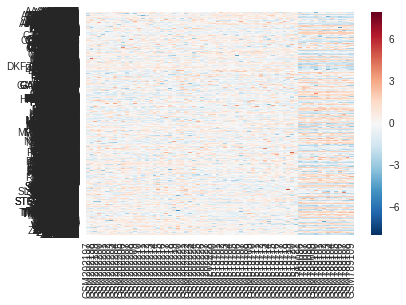

In [284]:
clin_data_old

In [285]:
exp_data_old